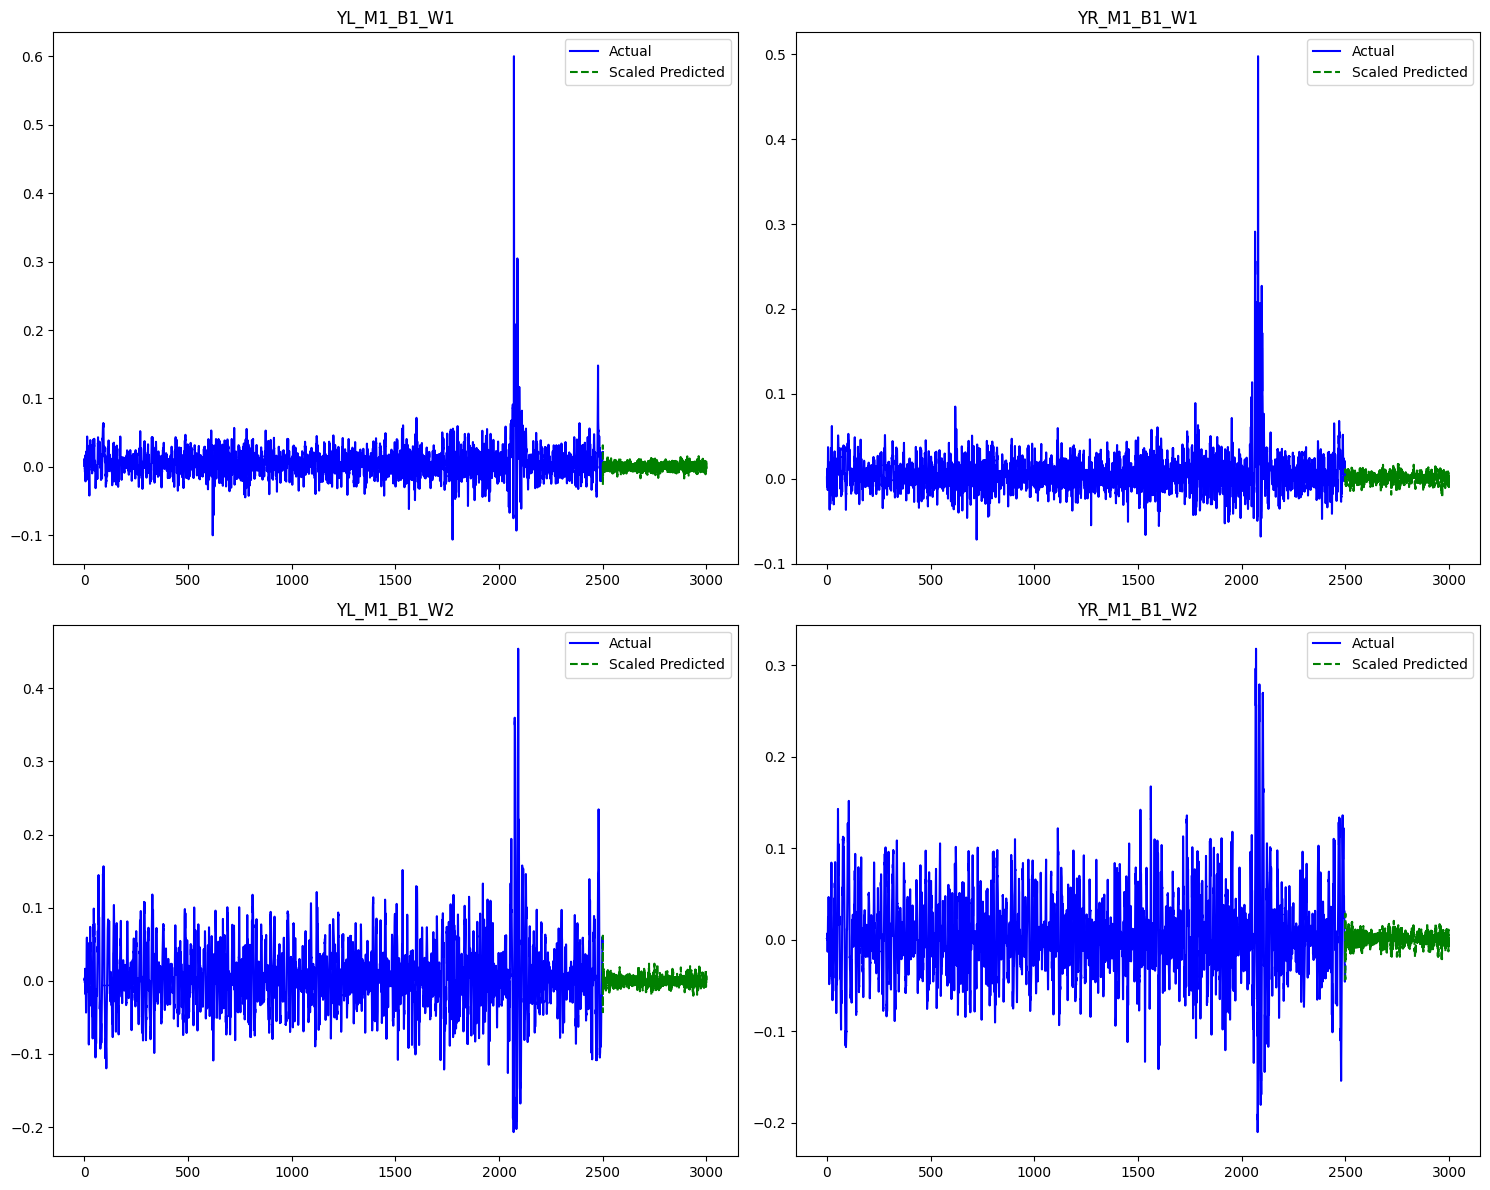

1999
2000


In [20]:
# 기본 선형회귀
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 데이터 불러오기
train_data_path = "data_s30.csv"
lane_data_path = "lane_data_s.csv"

train_data = pd.read_csv(train_data_path)
lane_data = pd.read_csv(lane_data_path)

# Train 데이터에 대한 전처리: Distance를 기준으로 학습 데이터와 선로 데이터 병합
merged_data = pd.merge(train_data, lane_data, on="Distance", how="left")

# Distance 2500~3000 범위를 예측 대상으로 분리
test_data = merged_data[merged_data["Distance"] >= 2500].copy()
train_data = merged_data[merged_data["Distance"] < 2500].copy()

# 데이터 변환 함수 정의
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -4:])
    return np.array(dataX), np.array(dataY)

# 데이터 변환 수행
features = merged_data.columns.difference(["YL_M1_B1_W1", "YR_M1_B1_W1", "YL_M1_B1_W2", "YR_M1_B1_W2", "Distance"]).to_list()
look_back = 5
X_seq, y_seq = create_dataset(merged_data[features + ["YL_M1_B1_W1", "YR_M1_B1_W1", "YL_M1_B1_W2", "YR_M1_B1_W2"]].values, look_back)

# 학습 및 예측 데이터 분리
X_train_seq = X_seq[:len(train_data) - look_back]
y_train_seq = y_seq[:len(train_data) - look_back]
X_test_seq = X_seq[len(train_data) - look_back:]
y_test_seq = y_seq[len(train_data) - look_back:]

# 선형 회귀 모델 학습
partial_train_size = 500
X_train_partial = X_train_seq[-partial_train_size:]
y_train_partial = y_train_seq[-partial_train_size:]
X_train_partial_reshaped = X_train_partial.reshape((X_train_partial.shape[0], -1))
X_test_seq_reshaped = X_test_seq.reshape((X_test_seq.shape[0], -1))

linear_model = LinearRegression()
linear_model.fit(X_train_partial_reshaped, y_train_partial)
predictions_linear = linear_model.predict(X_test_seq_reshaped)

# 곡률에 따른 스케일 팩터 계산
max_curvature = lane_data["Curvature"].max()
min_curvature = lane_data["Curvature"].min()
scale_factor_range = (1, 1)
lane_data["scale_factor"] = lane_data["Curvature"].apply(lambda x: ((x - min_curvature) / (max_curvature - min_curvature) * (scale_factor_range[1] - scale_factor_range[0])) + scale_factor_range[0])

# 스케일 팩터로 예측값 조정
scaled_predictions = predictions_linear.copy()
for i, distance in enumerate(test_data["Distance"]):
    scale_factor = lane_data[lane_data["Distance"] == distance]["scale_factor"].values[0]
    scaled_predictions[i] *= scale_factor

# 결과 시각화
plt.figure(figsize=(15, 12))
target_columns = ["YL_M1_B1_W1", "YR_M1_B1_W1", "YL_M1_B1_W2", "YR_M1_B1_W2"]
for idx, col in enumerate(target_columns, 1):
    plt.subplot(2, 2, idx)
    plt.plot(train_data["Distance"], train_data[col], label='Actual', color='blue')
    plt.plot(test_data["Distance"], scaled_predictions[:, idx - 1], label='Scaled Predicted', color='green', linestyle='dashed')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

# 'answer_sample.csv' 파일 읽기
answer_sample_path = "answer_sample.csv"
answer_sample = pd.read_csv(answer_sample_path)

print(len(answer_sample['YL_M1_B1_W1_s30'][:len(scaled_predictions)]))
print(len(scaled_predictions[:, 0]))

# 예측값을 해당 컬럼에 입력
answer_sample['YL_M1_B1_W1_s30'][:len(scaled_predictions) - 1] = scaled_predictions[:-1, 0]
answer_sample['YR_M1_B1_W1_s30'][:len(scaled_predictions) - 1] = scaled_predictions[:-1, 1]
answer_sample['YL_M1_B1_W2_s30'][:len(scaled_predictions) - 1] = scaled_predictions[:-1, 2]
answer_sample['YR_M1_B1_W2_s30'][:len(scaled_predictions) - 1] = scaled_predictions[:-1, 3]

# 변경된 데이터를 'answer_sample.csv' 파일에 다시 저장
answer_sample.to_csv(answer_sample_path, index=False)


In [27]:
#기본 트랜스포머
import pandas as pd

# Read the first few rows of the uploaded CSV file
data_c30 = pd.read_csv('data_c30.csv')
data_c30.head()

# Read the first few rows of the lane data CSV file
lane_data_c = pd.read_csv('lane_data_c.csv')
lane_data_c.head()

# Merge the two datasets based on the 'Distance' column
merged_data = pd.merge(data_c30, lane_data_c, on='Distance')

# Filter the data for the specified Distance range
filtered_data = merged_data[(merged_data['Distance'] <= 2500)]
filtered_data.head()

from sklearn.model_selection import train_test_split

# Define the target columns (derailment coefficients)
target_cols = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']

# Define the features columns
features_cols = [col for col in filtered_data.columns if col not in ['Distance'] + target_cols]

# Split the data into training and test sets
train_data, test_data = train_test_split(filtered_data, test_size=0.25, shuffle=False)

# Define the training features and targets
X_train = train_data[features_cols].values
y_train = train_data[target_cols].values

# Define the test features and targets
X_test = test_data[features_cols].values
y_test = test_data[target_cols].values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

import numpy as np

def create_sequences(data, target, input_sequence_length, target_sequence_length):
    """
    Create sequences of input data and corresponding target data.
    """
    input_sequences = []
    target_sequences = []

    for i in range(len(data) - input_sequence_length - target_sequence_length + 1):
        input_sequences.append(data[i:i+input_sequence_length])
        target_sequences.append(target[i+input_sequence_length:i+input_sequence_length+target_sequence_length])

    return np.array(input_sequences), np.array(target_sequences)

# Define the input sequence and target sequence lengths
input_sequence_length = 10  # Use 10 timesteps for input
target_sequence_length = 1  # Predict 1 timestep ahead

# Create sequences for training data
X_train_seq, y_train_seq = create_sequences(X_train, y_train, input_sequence_length, target_sequence_length)

# Create sequences for test data
X_test_seq, y_test_seq = create_sequences(X_test, y_test, input_sequence_length, target_sequence_length)

X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers):
        super(TransformerModel, self).__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers)
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.encoder(src)
        output = self.transformer(src, src)
        return self.decoder(output)

# Hyperparameters
d_model = 64
nhead = 8
num_encoder_layers = 3
input_dim = X_train_seq.shape[-1]
output_dim = y_train_seq.shape[-1]

# Create the model
model = TransformerModel(input_dim, output_dim, d_model, nhead, num_encoder_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32), torch.tensor(y_train_seq, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
for epoch in range(3):  # Number of epochs
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item()}")

import matplotlib.pyplot as plt

# 0~2500 범위의 데이터 필터링
past_data = merged_data[(merged_data['Distance'] >= 0) & (merged_data['Distance'] <= 2500)]

# 예측 데이터 생성
predicted = model(torch.tensor(X_test_seq, dtype=torch.float32)).detach().numpy()

# 마지막 타임스텝의 예측값만 사용
predicted_last = predicted[:, -1, :]

# 시각화 함수 정의
def plot_predictions(past_data, predicted, target_cols):
    fig, axes = plt.subplots(nrows=len(target_cols), ncols=1, figsize=(10, 15))

    for i, col in enumerate(target_cols):
        # 과거 데이터 그리기
        axes[i].plot(past_data['Distance'], past_data[col], label='Past Data', color='blue')

        # 예측한 데이터 시작점 계산
        start_point = int(past_data['Distance'].max()) + input_sequence_length
        end_point = start_point + len(predicted)
        predicted_distances = range(start_point, end_point)

        # 예측 데이터 그리기
        axes[i].plot(predicted_distances, predicted[:, i], label='Predicted', color='red')
        axes[i].set_title(col)
        axes[i].legend()

    plt.tight_layout()
    plt.show()


# 그래프 그리기
plot_predictions(past_data, predicted_last, target_cols)

# 'answer_sample.csv' 파일 읽기
answer_sample = pd.read_csv('answer_sample.csv')

# 예측값을 해당 컬럼에 입력
answer_sample['YL_M1_B1_W1_c30'][:len(predicted_last)] = predicted_last[:, 0]
answer_sample['YR_M1_B1_W1_c30'][:len(predicted_last)] = predicted_last[:, 1]
answer_sample['YL_M1_B1_W2_c30'][:len(predicted_last)] = predicted_last[:, 2]
answer_sample['YR_M1_B1_W2_c30'][:len(predicted_last)] = predicted_last[:, 3]

# 변경된 데이터를 'answer_sample.csv' 파일에 다시 저장
answer_sample.to_csv('answer_sample.csv', index=False)


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 4])) that is different to the input size (torch.Size([32, 10, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2, 1, 4])) that is different to the input size (torch.Size([2, 10, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 0.0075574652291834354
Epoch 2/10, Loss: 0.0026564220897853374
Epoch 3/10, Loss: 0.0008586879121139646


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1985625920 bytes.

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 4])) that is different to the input size (torch.Size([32, 10, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([18, 1, 4])) that is different to the input size (torch.Size([18, 10, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 0.0030158490408211946
Epoch 2/10, Loss: 0.002459620824083686
Epoch 3/10, Loss: 0.002058285754173994
Epoch 4/10, Loss: 0.0016098814085125923
Epoch 5/10, Loss: 0.0012014744570478797
Epoch 6/10, Loss: 0.0008793551241979003
Epoch 7/10, Loss: 0.0007237736717797816
Epoch 8/10, Loss: 0.0005187182105146348
Epoch 9/10, Loss: 0.0003752041084226221
Epoch 10/10, Loss: 0.0003184295492246747


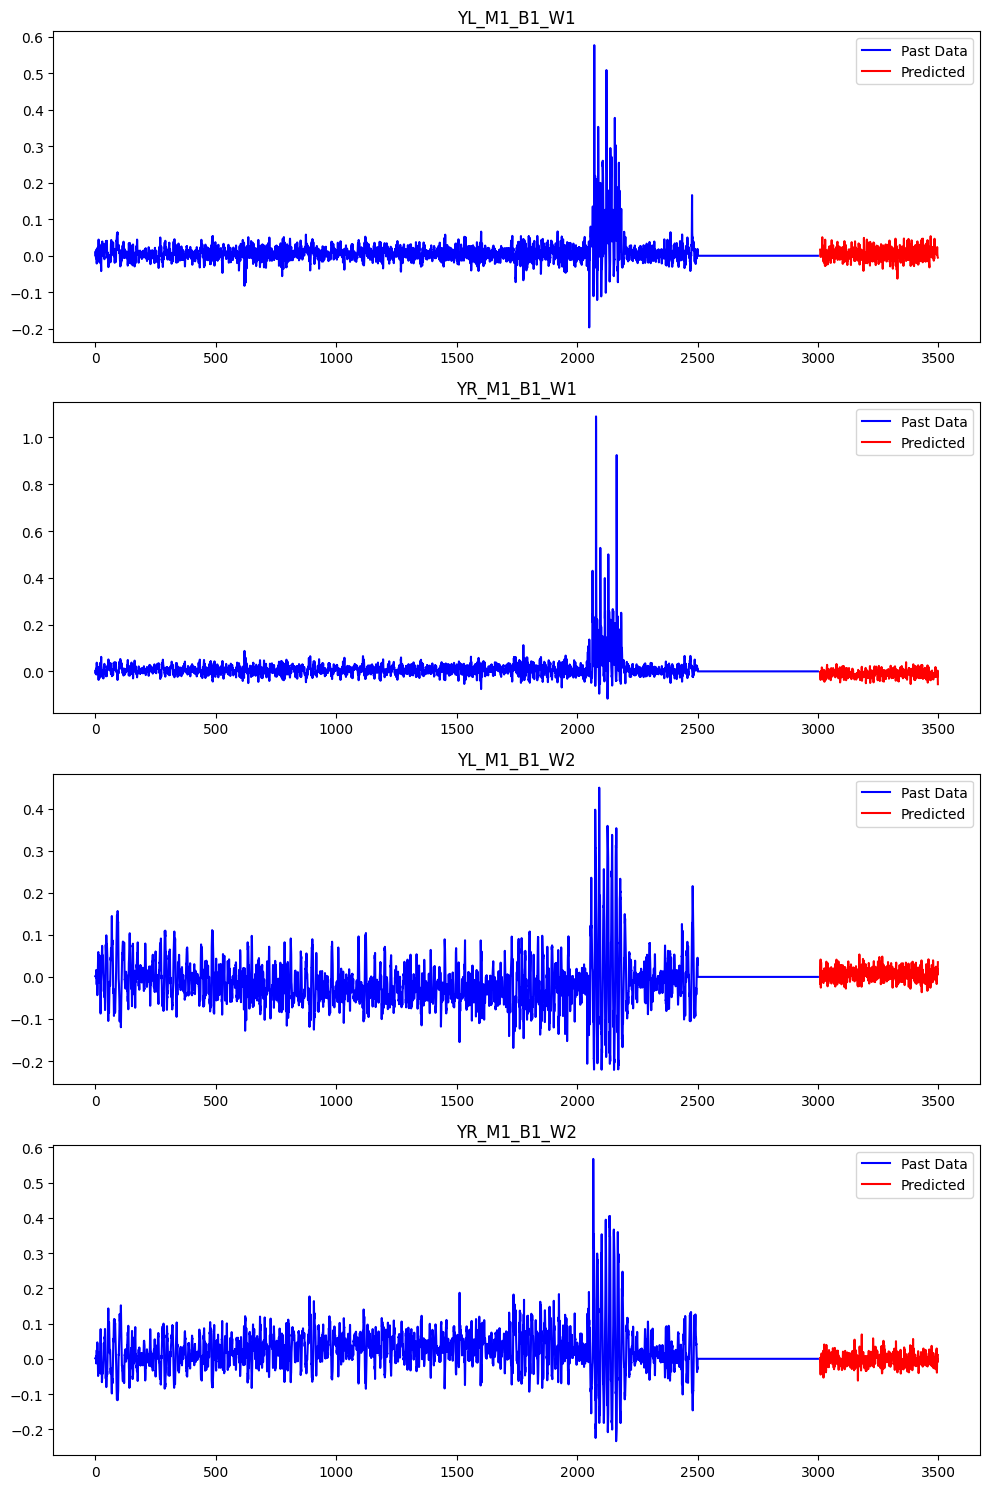

In [1]:
# 트랜스포머 + 앙상블
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 데이터 로딩
data_c30 = pd.read_csv('data_c30.csv')
lane_data_c = pd.read_csv('lane_data_c.csv')
merged_data = pd.merge(data_c30, lane_data_c, on='Distance')
filtered_data = merged_data[(merged_data['Distance'] >= 2500) & (merged_data['Distance'] <= 3000)]

# 데이터 분할
target_cols = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']
features_cols = [col for col in filtered_data.columns if col not in ['Distance'] + target_cols]
train_data, test_data = train_test_split(filtered_data, test_size=0.25, shuffle=False)
X_train = train_data[features_cols].values
y_train = train_data[target_cols].values
X_test = test_data[features_cols].values
y_test = test_data[target_cols].values

# 시퀀스 생성
def create_sequences(data, target, input_sequence_length, target_sequence_length):
    input_sequences = []
    target_sequences = []
    for i in range(len(data) - input_sequence_length - target_sequence_length + 1):
        input_sequences.append(data[i:i+input_sequence_length])
        target_sequences.append(target[i+input_sequence_length:i+input_sequence_length+target_sequence_length])
    return np.array(input_sequences), np.array(target_sequences)

input_sequence_length = 10
target_sequence_length = 1
X_train_seq, y_train_seq = create_sequences(X_train, y_train, input_sequence_length, target_sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, input_sequence_length, target_sequence_length)

# 트랜스포머 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers):
        super(TransformerModel, self).__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers)
        self.decoder = nn.Linear(d_model, output_dim)
    def forward(self, src):
        src = self.encoder(src)
        output = self.transformer(src, src)
        return self.decoder(output)

# 앙상블 트랜스포머 모델 정의
class EnsembleTransformer(nn.Module):
    def __init__(self, num_models, input_dim, output_dim, d_model, nhead, num_encoder_layers):
        super(EnsembleTransformer, self).__init__()
        self.models = nn.ModuleList([
            TransformerModel(input_dim, output_dim, d_model, nhead, num_encoder_layers)
            for _ in range(num_models)
        ])
    def forward(self, src):
        outputs = [model(src) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)

# 하이퍼파라미터 설정 및 모델 생성
d_model = 64
nhead = 8
num_encoder_layers = 3
input_dim = X_train_seq.shape[-1]
output_dim = y_train_seq.shape[-1]
num_models = 5
ensemble_model = EnsembleTransformer(num_models, input_dim, output_dim, d_model, nhead, num_encoder_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

# 데이터 로더 설정
train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32), torch.tensor(y_train_seq, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 학습
for epoch in range(10):
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = ensemble_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item()}")

# 예측
ensemble_predicted = ensemble_model(torch.tensor(X_test_seq, dtype=torch.float32)).detach().numpy()

# 시각화
def plot_predictions(past_data, predicted, target_cols):
    fig, axes = plt.subplots(nrows=len(target_cols), ncols=1, figsize=(10, 15))
    predicted_last = predicted[:, -1, :]
    for i, col in enumerate(target_cols):
        axes[i].plot(past_data['Distance'], past_data[col], label='Past Data', color='blue')
        start_point = int(past_data['Distance'].max()) + input_sequence_length
        end_point = start_point + len(predicted_last)
        predicted_distances = range(start_point, end_point)
        axes[i].plot(predicted_distances, predicted_last[:, i], label='Predicted', color='red')
        axes[i].set_title(col)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

plot_predictions(merged_data, ensemble_predicted, target_cols)



c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 4])) that is different to the input size (torch.Size([32, 10, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([30, 1, 4])) that is different to the input size (torch.Size([30, 10, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 0.002613087184727192
Epoch 2/10, Loss: 0.0025801516603678465
Epoch 3/10, Loss: 0.0028451133985072374
Epoch 4/10, Loss: 0.0012647282565012574
Epoch 5/10, Loss: 0.0018774546915665269
Epoch 6/10, Loss: 0.0029592521023005247
Epoch 7/10, Loss: 0.0014198309509083629
Epoch 8/10, Loss: 0.0007327659986913204
Epoch 9/10, Loss: 0.0008699165773577988
Epoch 10/10, Loss: 0.0010424264473840594


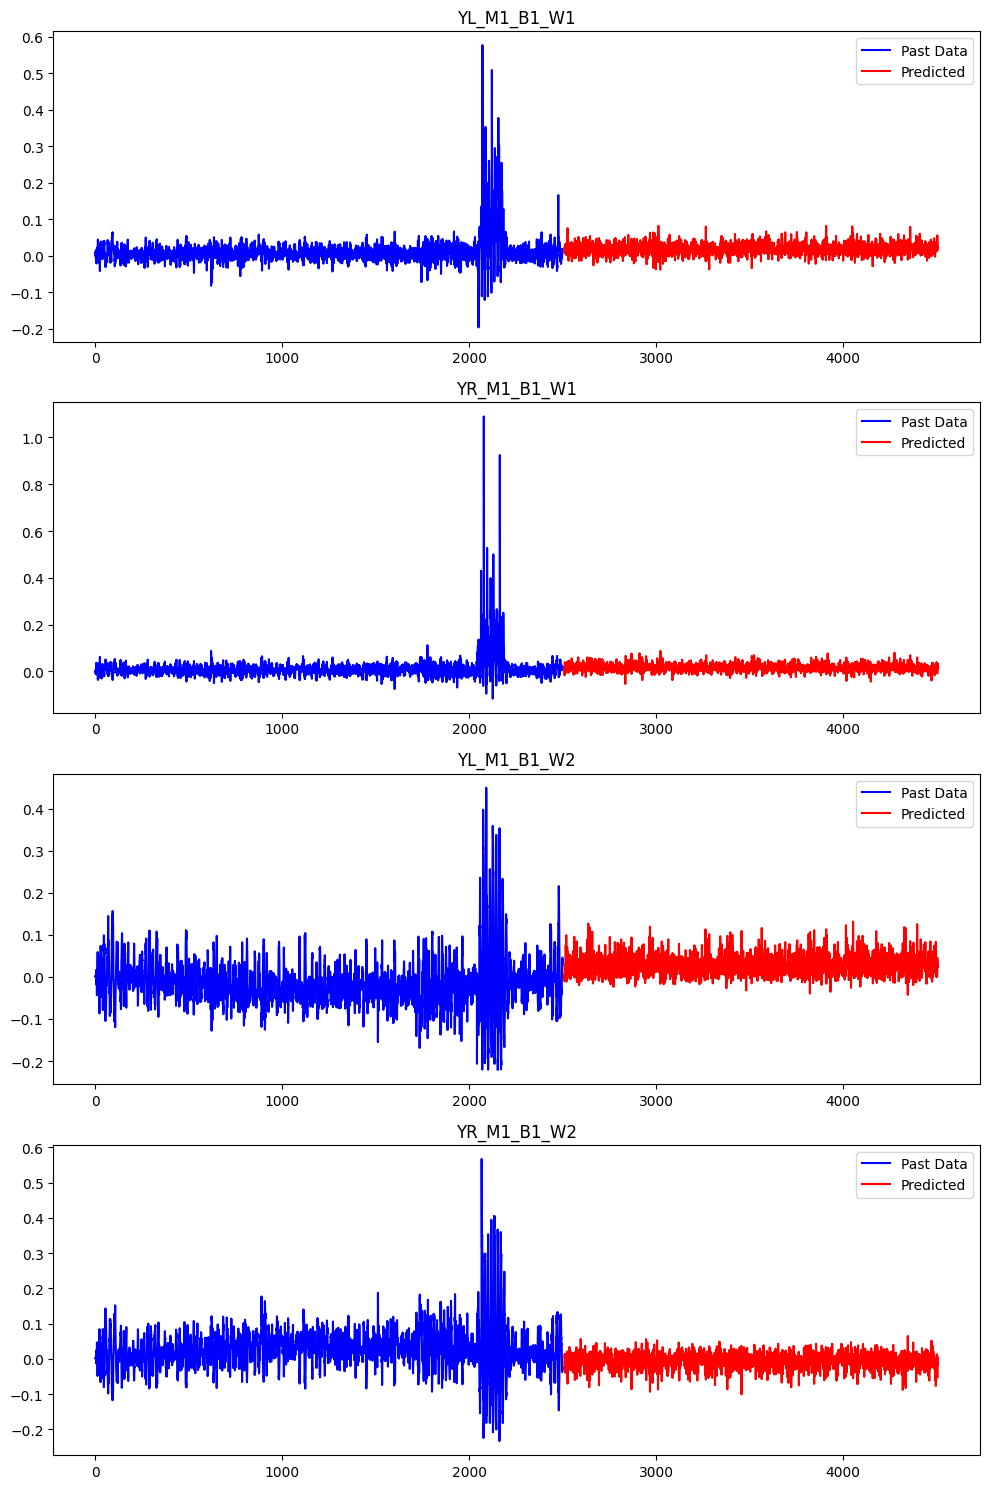

1999
2000


In [24]:
# 최종 트랜스포머
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 데이터 읽기
data_c30 = pd.read_csv('data_c30.csv')
lane_data_c = pd.read_csv('lane_data_c.csv')

# 데이터 병합
merged_data = pd.merge(data_c30, lane_data_c, on='Distance')

# 데이터 필터링
filtered_data = merged_data[(merged_data['Distance'] <= 2500)]

# 타겟 및 피처 정의
target_cols = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']
features_cols = [col for col in filtered_data.columns if col not in ['Distance'] + target_cols]

# 데이터 분할
train_data, test_data = train_test_split(filtered_data, test_size=0.25, shuffle=False)
X_train = train_data[features_cols].values
y_train = train_data[target_cols].values
X_test = test_data[features_cols].values
y_test = test_data[target_cols].values

# 시퀀스 생성 함수
def create_sequences(data, target, input_sequence_length, target_sequence_length):
    input_sequences = []
    target_sequences = []
    for i in range(len(data) - input_sequence_length - target_sequence_length + 1):
        input_sequences.append(data[i:i+input_sequence_length])
        target_sequences.append(target[i+input_sequence_length:i+input_sequence_length+target_sequence_length])
    return np.array(input_sequences), np.array(target_sequences)

input_sequence_length = 10
target_sequence_length = 1
X_train_seq, y_train_seq = create_sequences(X_train, y_train, input_sequence_length, target_sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, input_sequence_length, target_sequence_length)

# 트랜스포머 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers):
        super(TransformerModel, self).__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers)
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.encoder(src)
        output = self.transformer(src, src)
        return self.decoder(output)

d_model = 64
nhead = 8
num_encoder_layers = 3
input_dim = X_train_seq.shape[-1]
output_dim = y_train_seq.shape[-1]
model = TransformerModel(input_dim, output_dim, d_model, nhead, num_encoder_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 데이터를 PyTorch 텐서로 변환
train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32), torch.tensor(y_train_seq, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 학습 루프
for epoch in range(10):
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item()}")

# 예측 루프
last_known_data = filtered_data[-input_sequence_length:]
predictions = []
for _ in range((4499 - 2500) // target_sequence_length):
    input_seq = torch.tensor(last_known_data[features_cols].values, dtype=torch.float32).unsqueeze(0)
    predicted_seq = model(input_seq).detach().numpy()[0, -1, :]
    predictions.append(predicted_seq)

    new_row = pd.DataFrame([last_known_data.iloc[-1].copy()])
    new_row['Distance'] += target_sequence_length
    new_row[target_cols] = predicted_seq
    last_known_data = pd.concat([last_known_data, new_row], ignore_index=True)
    last_known_data = last_known_data.iloc[-input_sequence_length:]

# 시각화
def plot_predictions(past_data, predicted, target_cols):
    fig, axes = plt.subplots(nrows=len(target_cols), ncols=1, figsize=(10, 15))
    for i, col in enumerate(target_cols):
        axes[i].plot(past_data['Distance'], past_data[col], label='Past Data', color='blue')
        start_point = int(past_data['Distance'].max()) + input_sequence_length
        end_point = start_point + len(predicted)
        predicted_distances = range(start_point, end_point)
        axes[i].plot(predicted_distances, predicted[:, i], label='Predicted', color='red')
        axes[i].set_title(col)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

#리스트를 넘파이어레이로 변환
predicted_data = np.array(predictions)

plot_predictions(filtered_data, predicted_data, target_cols)

# 'answer_sample.csv' 파일에 예측값 저장
answer_sample = pd.read_csv('answer_sample.csv')
answer_sample['YL_M1_B1_W1_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 0]
answer_sample['YR_M1_B1_W1_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 1]
answer_sample['YL_M1_B1_W2_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 2]
answer_sample['YR_M1_B1_W2_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 3]
answer_sample.to_csv('answer_sample.csv', index=False)